In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import re
import h3
import datetime
import os

In [128]:
# building_df = pd.read_csv('OpenStreetMap/B_features.csv')

poi_df = pd.read_csv('OpenStreetMap/A_features.csv')
poi_df = poi_df[['osmid', 'amenity', 'ele', 'denomination', 'brand', 'cuisine',
                    'healthcare', 'parking', 'geometry', 'height']]

lat = []
lon = []
h3_l7 = []

for i in range(poi_df.shape[0]):
    if len(re.findall("\d+\.?\d*", poi_df.geometry[i])) < 3:
        poi_df = poi_df.drop(i, axis=0)
    else:
        latitute = float(re.findall("\d+\.?\d*", poi_df.geometry[i])[1])
        longitute = -float(re.findall("\d+\.?\d*", poi_df.geometry[i])[0])
        lat.append(latitute)
        lon.append(longitute)
        h3_l7.append(h3.geo_to_h3(latitute, longitute, resolution=7))

poi_df.drop('geometry', axis=1)
poi_df['lat'] = lat
poi_df['lon'] = lon
poi_df['h3_l7'] = h3_l7

min_lat = min(poi_df['lat'])
max_lat = max(poi_df['lat'])
min_lon = min(poi_df['lon'])
max_lon = max(poi_df['lon'])

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\1295220697.py:12: SyntaxWarning: invalid escape sequence '\d'
  if len(re.findall("\d+\.?\d*", poi_df.geometry[i])) < 3:
C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\1295220697.py:15: SyntaxWarning: invalid escape sequence '\d'
  latitute = float(re.findall("\d+\.?\d*", poi_df.geometry[i])[1])
C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\1295220697.py:16: SyntaxWarning: invalid escape sequence '\d'
  longitute = -float(re.findall("\d+\.?\d*", poi_df.geometry[i])[0])


In [129]:
poi_df

,osmid,amenity,ele,denomination,brand,cuisine,healthcare,parking,geometry,height,lat,lon,h3_l7
1001,37918264,school,3.0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-75.9867903 36.8503488, -75.9830533 ...",NaN,36.850349,-75.986790,872af636cffffff
1002,38028116,school,7.0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.142903 36.8972026, -76.1422866 3...",NaN,36.897203,-76.142903,872af6309ffffff
1003,38028120,school,6.0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.1475633 36.8993867, -76.1472308 ...",NaN,36.899387,-76.147563,872af6309ffffff
1004,38054683,school,3.0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-75.9790256 36.8416749, -75.9802156 ...",NaN,36.841675,-75.979026,872af636dffffff
1005,38054722,parking,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.0349931 36.8481908, -76.0344696 ...",NaN,36.848191,-76.034993,872af636affffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3478,13825469,place_of_worship,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.1538648 36.8539233, -76.1539677 ...",NaN,36.853923,-76.153865,872af6353ffffff
3479,14020613,place_of_worship,3.0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.0508324 36.7575045, -76.0507696 ...",NaN,36.757505,-76.050832,872af0c92ffffff
3480,14325039,clinic,NaN,NaN,NaN,NaN,clinic,NaN,"POLYGON ((-76.1394903 36.8726629, -76.1394848 ...",NaN,36.872663,-76.139490,872af6350ffffff
3481,14756225,parking,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.0264763 36.8578009, -76.0260954 ...",NaN,36.857801,-76.026476,872af636effffff


In [130]:
ohca_df = pd.read_csv('OHCAs.csv')
h3_l7 = []

for i in range(ohca_df.shape[0]):
    h3_l7.append(h3.geo_to_h3(ohca_df.Latitude[i], ohca_df.Longitude[i], resolution=7))

ohca_df['h3_l7'] = h3_l7

if min_lat < min(ohca_df['Latitude']): min_lat = min(ohca_df['Latitude'])
if max_lat > max(ohca_df['Latitude']): max_lat = max(ohca_df['Latitude'])
if min_lon < min(ohca_df['Longitude']): min_lon = min(ohca_df['Longitude'])
if max_lon > max(ohca_df['Longitude']): max_lon = max(ohca_df['Longitude'])

ohca_df = ohca_df.drop_duplicates(subset=['ReceivedTime', 'Latitude', 'Longitude'])
ohca_df['ReceivedTime'] = pd.to_datetime(ohca_df['ReceivedTime'])
ohca_df['ReceivedTime'] = ohca_df['ReceivedTime'].apply(lambda x: x.date())

In [131]:
ohca_df

,ID_OHCA,ReceivedTime,MinimumResponseTime,Latitude,Longitude,Incident_Location,h3_l7
0,1,2017-01-01,5.666667,36.862471,-76.024169,1000 LINDSLEY DR\r,872af636effffff
1,2,2017-01-01,20.750000,36.766897,-76.042337,2600 SPRINGHAVEN DR\r,872af0c96ffffff
3,4,2017-01-01,11.083333,36.905880,-76.118769,4200 SHORE DR\r,872af6372ffffff
4,5,2017-01-01,0.000000,36.620850,-76.090090,5200 BLACKWATER RD\r,872af0515ffffff
5,6,2017-01-02,0.000000,36.784458,-76.108918,3800 TIFFANY LA\r,872af6266ffffff
...,...,...,...,...,...,...,...
2699,2700,2019-06-28,9.650000,36.789220,-75.978720,600 FLEET DR\r,872af0cb0ffffff
2701,2702,2019-06-29,4.883333,36.842390,-76.145965,200 ARAGONA BL\r,872af635effffff
2702,2703,2019-06-29,4.666667,36.792043,-76.167430,5300 LACROSSE CT\r,872af6274ffffff
2703,2704,2019-06-29,11.400000,36.804559,-76.183715,1200 GENERAL ST\r,872af6276ffffff


In [132]:
ems_df = pd.read_csv('EMS_Calls_For_Service.csv')
ems_df = ems_df[ems_df['IncidentTypeDescription'] == 'CARDIAC ARREST']
ems_df = ems_df.drop_duplicates(subset=['IncidentNumber'], keep='first')
ems_df = ems_df[['IncidentNumber', 'RECEIVED_TIME', 'Block', 'Street Name']]
ems_df = ems_df.dropna(subset=['Street Name'])
ems_df.loc[ems_df.Block.isna(), 'Block'] = 0
ems_df['Block'] = ems_df.Block.astype('int')
ems_df.RECEIVED_TIME = pd.to_datetime(ems_df.RECEIVED_TIME)
ems_df['Date'] = ems_df['RECEIVED_TIME'].apply(lambda x: x.date())
ems_df['Hour'] = ems_df['RECEIVED_TIME'].apply(lambda x: x.hour)
ems_df.reset_index(inplace = True)
ems_df = ems_df.drop(['index'], axis=1)

In [133]:
start_date = ems_df.loc[0, 'Date']
end_date = ems_df.loc[ems_df.shape[0]-1, 'Date']
delta = datetime.timedelta(days=1)
current_date = start_date

while (current_date <= end_date):
    today_ems = ems_df[ems_df['Date'] == current_date]
    today_ohca = ohca_df[ohca_df['ReceivedTime'] == current_date]
    
    if today_ems.shape[0] == 0 or today_ohca.shape[0] == 0:
        current_date += delta
        continue

    for i in today_ems.index:
        stna = today_ems.loc[i, 'Street Name'].split(' ')[0]
        row = np.logical_and(np.array(ohca_df['ReceivedTime'] == current_date),
                np.array(ohca_df['Incident_Location'].apply(lambda x: x.find(stna) >=0))
                )

        ind = []
        for j in today_ohca.index:
            if today_ohca.loc[j, 'Incident_Location'].find(stna) >= 0 or \
                today_ohca.loc[j, 'Incident_Location'].find(str(today_ems.loc[i, 'Block'])) >= 0:
                ind.append(j)
                continue
        ohca_df.loc[ind, 'Time'] = today_ems.loc[i, 'RECEIVED_TIME']
        ems_df = ems_df.drop(i, axis=0)
        
    current_date += delta
    
ohca_df = ohca_df.dropna(subset=['Time'])

In [134]:
ohca_df

,ID_OHCA,ReceivedTime,MinimumResponseTime,Latitude,Longitude,Incident_Location,h3_l7,Time
0,1,2017-01-01,5.666667,36.862471,-76.024169,1000 LINDSLEY DR\r,872af636effffff,2017-01-01 00:49:54
1,2,2017-01-01,20.750000,36.766897,-76.042337,2600 SPRINGHAVEN DR\r,872af0c96ffffff,2017-01-01 06:35:29
3,4,2017-01-01,11.083333,36.905880,-76.118769,4200 SHORE DR\r,872af6372ffffff,2017-01-01 17:05:56
4,5,2017-01-01,0.000000,36.620850,-76.090090,5200 BLACKWATER RD\r,872af0515ffffff,2017-01-01 19:53:20
5,6,2017-01-02,0.000000,36.784458,-76.108918,3800 TIFFANY LA\r,872af6266ffffff,2017-01-02 10:50:59
...,...,...,...,...,...,...,...,...
2698,2699,2019-06-27,5.483333,36.866925,-76.023730,1600 OLD DONATION PKWY\r,872af6363ffffff,2019-06-27 14:28:53
2699,2700,2019-06-28,9.650000,36.789220,-75.978720,600 FLEET DR\r,872af0cb0ffffff,2019-06-28 08:02:43
2701,2702,2019-06-29,4.883333,36.842390,-76.145965,200 ARAGONA BL\r,872af635effffff,2019-06-29 11:09:50
2703,2704,2019-06-29,11.400000,36.804559,-76.183715,1200 GENERAL ST\r,872af6276ffffff,2019-06-29 21:26:19


In [135]:
list_h3_l7 = np.unique(np.concatenate( (poi_df.h3_l7.unique(), ohca_df.h3_l7.unique())))
list_h3_l7.shape


(137,)

In [136]:
# h3_l7_nei = []
# for i in list_h3_l7:
#     nei = []
#     for j in list_h3_l7:
#         if i != j and h3.h3_indexes_are_neighbors(i, j):
#             nei.append(j)
    
#     if len(nei) == 0: print('no neighbour')

#     h3_l7_nei.append(nei)

In [137]:
cols = np.concatenate((
            poi_df.amenity.unique(),
            # np.array(['ele']),
            # poi_df.denomination.unique(),
            # poi_df.brand.unique(),
            # poi_df.cuisine.unique(),
            # poi_df.healthcare.unique(),
            # np.array(['multi-storey']),
        ))
len(cols)

h3_l7_df = pd.DataFrame(data={'id': np.unique(np.concatenate((poi_df.h3_l7.unique(), ohca_df.h3_l7.unique())))})
h3_l7_df[cols] = 0

for i in range(poi_df.shape[0]):
    h3_l7_id = poi_df.iloc[i]['h3_l7']
    h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['amenity']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['denomination']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['brand']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['cuisine']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['healthcare']] += 1

# # parking
# for i in poi_df[poi_df.parking == 'multi-storey']['h3_l7']:
#     h3_l7_df.loc[h3_l7_df['id'] == i, 'multi-storey'] += 1

In [138]:
h3_l7_df

,id,school,parking,grave_yard,college,hospital,fuel,place_of_worship,fast_food,stage,...,marketplace,car_rental,driving_school,payment_centre,dojo,gambling,bar,bicycle_parking,bbq,social_facility
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,872af0500ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133,872af6375ffffff,0,4,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
134,872af6acaffffff,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,872af6ad9ffffff,0,53,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
unique_h3_l7, counts = np.unique(np.array(ohca_df.h3_l7), return_counts = True)

In [140]:
h3_l7_df['ohca'] = 0
for i in range(len(unique_h3_l7)):
    h3_l7_df.loc[h3_l7_df.id == unique_h3_l7[i], 'ohca'] = counts[i]

In [141]:
h3_l7_df

,id,school,parking,grave_yard,college,hospital,fuel,place_of_worship,fast_food,stage,...,car_rental,driving_school,payment_centre,dojo,gambling,bar,bicycle_parking,bbq,social_facility,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
133,872af6375ffffff,0,4,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,17
134,872af6acaffffff,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
135,872af6ad9ffffff,0,53,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,2


In [142]:
police_record = pd.read_csv('police_record_2_hours.csv')

In [143]:
for i in range(int(10933*2/24)-1):
    police_record.iloc[12*i, 6:] = np.sum(police_record.iloc[12*i:12*i+11, 6:])
police_record = police_record.iloc[[12*i for i in range(int(10933/12)+1)]].copy()

c:\Users\Yuan\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Yuan\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Yuan\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwa

In [144]:
police_h3_l7 = np.sum(police_record.iloc[:, 6:])
police_h3_l7


c:\Users\Yuan\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


872af0424ffffff       4.0
872af0425ffffff       0.0
872af0426ffffff       0.0
872af0500ffffff      99.0
872af0501ffffff       4.0
                    ...  
872af6373ffffff      68.0
872af6375ffffff    1101.0
872af6acaffffff      12.0
872af6ad9ffffff     302.0
872af6adbffffff       8.0
Length: 137, dtype: float64

In [145]:
h3_l7_df['police'] = 0
for i in range(len(police_h3_l7)):
    print(police_h3_l7[i])
    h3_l7_df.loc[h3_l7_df.id == police_h3_l7[i], 'police'] = police_h3_l7[i]

C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\4285346615.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(police_h3_l7[i])
C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\4285346615.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  h3_l7_df.loc[h3_l7_df.id == police_h3_l7[i], 'police'] = police_h3_l7[i]
C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\4285346615.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prin

4.0
0.0
0.0
99.0
4.0
34.0
48.0
67.0
1667.0
25.0
19.0
31.0
41.0
26.0
32.0
32.0
43.0
38.0
44.0
8.0
12.0
166.0
178.0
74.0
340.0
157.0
168.0
137.0
435.0
187.0
3531.0
87.0
971.0
1260.0
486.0
45.0
29.0
27.0
65.0
36.0
28.0
105.0
419.0
1146.0
1786.0
1226.0
338.0
1.0
715.0
0.0
401.0
118.0
504.0
1101.0
14.0
660.0
8.0
2993.0
1775.0
2418.0
392.0
2882.0
3388.0
3283.0
8.0
1375.0
53.0
810.0
196.0
1664.0
740.0
2166.0
448.0
98.0
96.0
1170.0
195.0
893.0
702.0
2178.0
2045.0
1381.0
9.0
1877.0
2.0
1325.0
312.0
484.0
5337.0
805.0
4369.0
311.0
2149.0
257.0
64.0
114.0
5016.0
392.0
16.0
128.0
2801.0
3812.0
1324.0
4491.0
3564.0
678.0
213.0
951.0
3046.0
3811.0
2017.0
1545.0
5269.0
3438.0
7830.0
21.0
191.0
276.0
920.0
160.0
543.0
53.0
7975.0
2833.0
4723.0
1109.0
5426.0
15851.0
1174.0
1049.0
319.0
638.0
68.0
1101.0
12.0
302.0
8.0


C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\4285346615.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(police_h3_l7[i])
C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\4285346615.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  h3_l7_df.loc[h3_l7_df.id == police_h3_l7[i], 'police'] = police_h3_l7[i]
C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\4285346615.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prin

In [146]:
h3_l7_df['police'] = np.array(police_h3_l7)

In [147]:
h3_l7_df

,id,school,parking,grave_yard,college,hospital,fuel,place_of_worship,fast_food,stage,...,car_rental,driving_school,payment_centre,dojo,gambling,bar,bicycle_parking,bbq,social_facility,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
133,872af6375ffffff,0,4,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,17
134,872af6acaffffff,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
135,872af6ad9ffffff,0,53,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,2


In [148]:
# h3_l7_id1 = np.random.choice(spatial_data.shape[0]-1, 2000)
# t_pivot1 = np.random.choice(temporal_train_data.shape[0]-window_size-1, 2000)

# pivot = np.random.choice(len(ohca_occur_train), 1000)
# t_pivot2 = ohca_occur_train[pivot][:, 0] - window_size
# h3_l7_id2 = ohca_occur_train[pivot][:, 1]

# h3_l7_id = np.concatenate((h3_l7_id1.reshape(-1,1), h3_l7_id2.reshape(-1,1)), axis=0)
# t_pivot = np.concatenate((t_pivot1.reshape(-1,1), t_pivot2.reshape(-1,1)), axis=0) 

# s_fea = np.array(spatial_data[h3_l7_id]).reshape(3000, -1)

# # t_fea = torch.autograd.Variable(torch.FloatTensor(
# #             np.concatenate((temporal_train_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]],
# #                             police_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
# #                     ))
# # # X_pred = regr_net(Y)
# # features = (torch.cat( (s_fea , t_fea[-1]), dim=0 ))

# t_pivot += window_size
# h3_l7_id_ = h3_l7_id + 4

# t_fea = np.concatenate((temporal_train_data[t_pivot, 0:4].reshape(3000,4), temporal_train_data[t_pivot-1, h3_l7_id_].reshape(3000,1)), axis=1) 
# t_fea = np.concatenate((t_fea, police_data[t_pivot, h3_l7_id].reshape((-1, 1))), axis=1)

# x = np.concatenate((s_fea, t_fea), axis=1)
# y = np.array([temporal_train_data[t_pivot, 4+h3_l7_id]]).reshape((3000, -1))
# xy = np.concatenate((x, y), axis=1)



xy = h3_l7_df.iloc[:, 1:]
corr_array = np.array(xy.corr().iloc[:, -1])
np.where(np.abs(corr_array) > 0.2), corr_array[np.where(np.abs(corr_array) > 0.2)]


((array([ 0,  1,  4,  5,  6,  7,  9, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23,
         24, 28, 29, 32, 52], dtype=int64),),
 array([0.56548095, 0.2395146 , 0.21387975, 0.54387897, 0.62753357,
        0.6105377 , 0.47714643, 0.29987261, 0.25977723, 0.43685502,
        0.22513526, 0.20547094, 0.50983232, 0.43519265, 0.21526826,
        0.75360131, 0.3296041 , 0.32096128, 0.23321314, 0.27743068,
        0.24143836, 1.        ]))

In [149]:
corr_array

array([ 0.56548095,  0.2395146 ,  0.07186813,  0.02454321,  0.21387975,
        0.54387897,  0.62753357,  0.6105377 ,  0.19558999,  0.47714643,
        0.09936181,  0.16890568,  0.29987261,  0.25977723,  0.43685502,
        0.22513526,  0.1387982 ,  0.20547094,  0.50983232,  0.43519265,
        0.21526826,  0.13405661,  0.75360131,  0.3296041 ,  0.32096128,
       -0.0860885 , -0.06623806,  0.04785633,  0.23321314,  0.27743068,
        0.04262074,  0.14656742,  0.24143836,  0.19558999,  0.19049572,
        0.08861044,  0.15483587,  0.00710222,  0.00710222,  0.08351618,
        0.10102687,  0.14974161,  0.13955308,  0.13955308,  0.03766781,
       -0.06421747,  0.08351618, -0.0183691 ,  0.19558999,  0.14974161,
        0.14974161,  0.07332765,  1.        ])

0
1
4
5
6
7
9
12
13
14
15
17
18
19
20
22
23
24
28
29
32
52


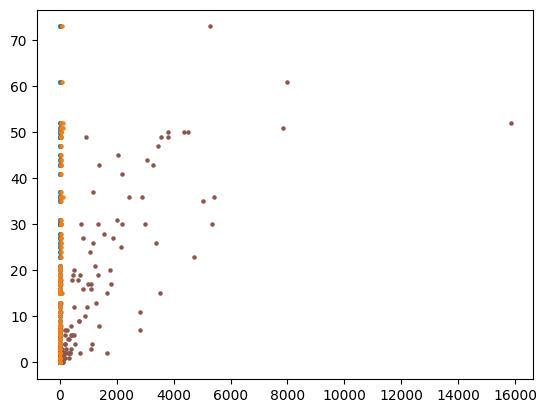

In [150]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
for i in np.where(np.abs(corr_array) > 0.2)[0]:
    print(i)
    plt.scatter(xy.iloc[:, i], xy.iloc[:, -1], s=5)
    #plt.show()

# officially trianing data

In [151]:
train_proportion = 0.6
valid_proportion = 0.2
test_proportion = 0.2

normalized_h3_l7_df = h3_l7_df.drop('id', axis=1)
normalized_h3_l7_df = (normalized_h3_l7_df - normalized_h3_l7_df.min())/(normalized_h3_l7_df.max() - normalized_h3_l7_df.min())
spatial_data = np.array(normalized_h3_l7_df).astype(np.float64)

# train_size = int(temporal_data.shape[0] * train_proportion)
# valid_size = int(temporal_data.shape[0] * valid_proportion)

# temporal_train_data = temporal_data[:train_size]
# temporal_valid_data = temporal_data[train_size:train_size+valid_size]
# temporal_test_data = temporal_data[train_size+valid_size:]

# police_train_data = police_data[:train_size]
# police_valid_data = police_data[train_size:train_size+valid_size]
# police_test_data = police_data[train_size+valid_size:]

batch_size = 100

In [152]:
h3_l7_df.iloc[:, 23]

0         4.0
1         0.0
2         0.0
3        99.0
4         4.0
        ...  
132      68.0
133    1101.0
134      12.0
135     302.0
136       8.0
Name: police, Length: 137, dtype: float64

In [153]:
# h3_l7_nei = []
# for i in list_h3_l7:
#     nei = []
#     for j in list_h3_l7:
#         if i != j and h3.h3_indexes_are_neighbors(i, j):
#             nei.append(j)
    
#     if len(nei) == 0: print('no neighbour')

#     h3_l7_nei.append(nei)

In [154]:
class Regressor(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32, output_size = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

class Regressor2(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32, output_size = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        output = F.sigmoid(output)
        return output

In [155]:
window_size = 1

In [183]:
train_size = int(spatial_data.shape[0]*0.7)

seed = 0
np.random.seed(seed)

h3_l7_id = np.random.choice(spatial_data.shape[0], spatial_data.shape[0])
spatial_data = spatial_data[h3_l7_id]
train_spatial_data = spatial_data[:train_size, :]
test_spatial_data = spatial_data[train_size:, :]

In [184]:
spatial_data.shape

(137, 53)

In [185]:
train_spatial_data.shape, test_spatial_data.shape, spatial_data.shape, train_size

((95, 53), (42, 53), (137, 53), 95)

In [186]:
def train_reg(spatial_data, 
                s_net, p_net,
                s_net_optim, p_net_optim,
                window_size, iter_num = 5000):

    loss_array = []
    t_fea_array = []
    s_fea_array = []

    for _ in tqdm(range(iter_num)):
        
        h3_l7_id = np.random.choice(spatial_data.shape[0]-1, window_size)

        s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1])))

        ohca = spatial_data[h3_l7_id, -1].reshape(-1,1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # X_pred = regr_net(Y)
        # p_pred = p_net(s_fea).reshape(-1,1)
        p_pred = s_fea.reshape(-1,1)

        mseloss = torch.nn.MSELoss(reduction = 'sum')
        # bceloss = torch.nn.BCELoss(reduction='none')
        loss = mseloss(p_pred, ohca)
        
        s_net_optim.zero_grad()
        p_net_optim.zero_grad()
        autograd.backward(loss)


        s_net_optim.step()
        p_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())
        # s_fea_array.append(s_fea.detach().cpu().numpy())
    
    return loss_array, t_fea_array, s_fea_array

s_net = Regressor(input_size = spatial_data.shape[1]-1, hidden_size = spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

p_net = Regressor(input_size = 32, hidden_size = 256, output_size = 1)
p_net_optim = optim.Adam(p_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net, p_net,
                                                    s_net_optim, p_net_optim,
                                                    window_size, iter_num = 30000)

100%|██████████| 30000/30000 [01:00<00:00, 496.49it/s]


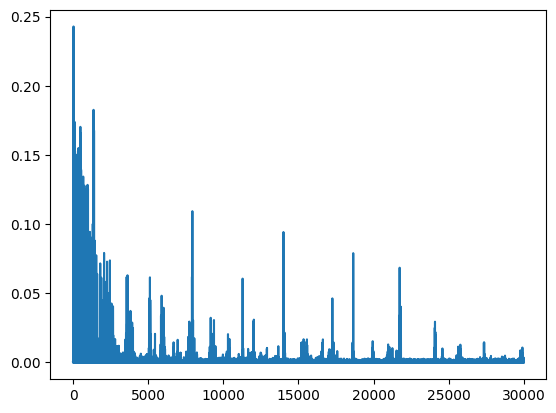

In [187]:
plt.plot(np.array(loss_array).reshape(30000))

In [188]:
(s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max()).shape,
(train_spatial_data[:, -1]*h3_l7_df.ohca.max()).shape

(95,)

Text(0, 0.5, 'Reality')

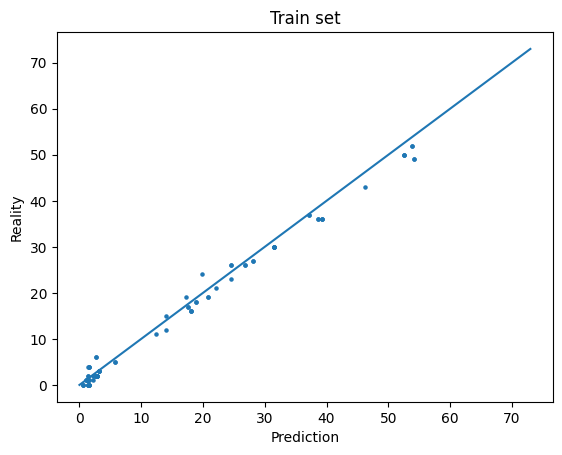

In [189]:
# plt.scatter(p_net(s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1])))).detach().cpu().numpy()*h3_l7_df.ohca.max(),
#             train_spatial_data[:, -1]*h3_l7_df.ohca.max(),
#             s = 5)
plt.scatter(s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max(),
            train_spatial_data[:, -1]*h3_l7_df.ohca.max(),
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Train set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Reality')

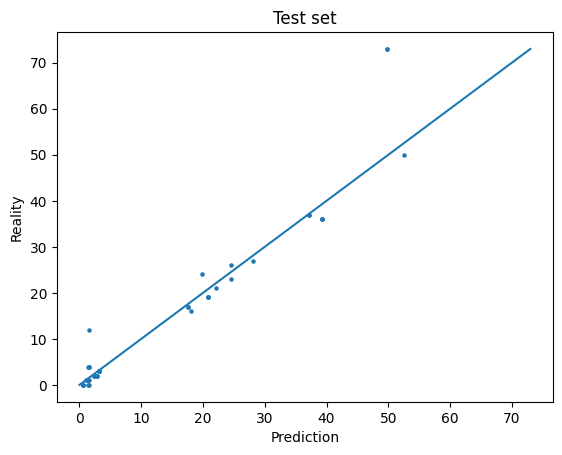

In [190]:
# plt.scatter(p_net(s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1])))).detach().cpu().numpy()*h3_l7_df.ohca.max(),
#             test_spatial_data[:, -1]*h3_l7_df.ohca.max(),
#             s = 5)
plt.scatter(s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max(),
            test_spatial_data[:, -1]*h3_l7_df.ohca.max(),
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Test set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Number of OHCA')

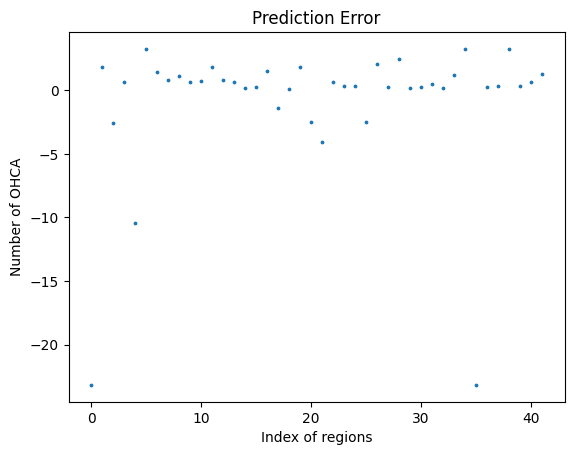

In [202]:
plt.scatter(np.arange(test_spatial_data.shape[0]),
            s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max()-
            test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max(),
            s = 3)
plt.title('Prediction Error')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\1373566590.py:2: RuntimeWarning: divide by zero encountered in divide
  (s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max()-


Text(0, 0.5, 'Number of OHCA')

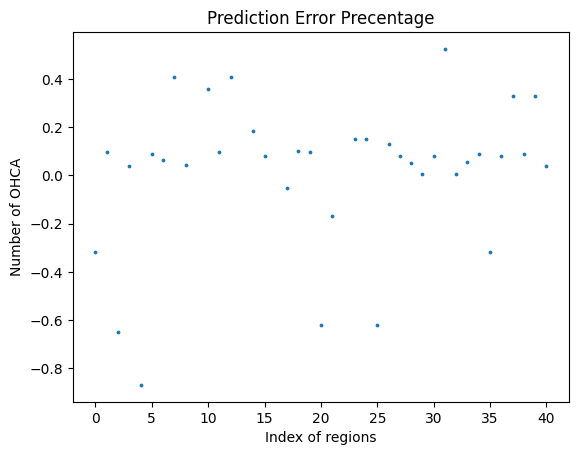

In [205]:

plt.scatter(np.arange(test_spatial_data.shape[0]),
            (s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max()-
            test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max())/test_spatial_data[:, -1].reshape(-1, 1)/h3_l7_df.ohca.max(),
            s = 3)
plt.title('Prediction Error Precentage')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')


In [209]:
mape_list = (s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max()-
            test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max())/(test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max()+1)

mape = mape_list[mape_list != np.inf].sum()/mape_list.shape[0]

mae = np.abs(s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().cpu().numpy()*h3_l7_df.ohca.max()- test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max())
mae = mae.sum()/mae.shape[0]

mae, mape

(2.5002312064170837, 0.1068603025741585)

In [38]:
def train_reg(spatial_data, 
                s_net, p_net,
                s_net_optim, p_net_optim,
                window_size, iter_num = 5000):

    loss_array = []
    t_fea_array = []
    s_fea_array = []

    for _ in tqdm(range(iter_num)):
        
        h3_l7_id = np.random.choice(spatial_data.shape[0]-1, window_size)

        s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1])))

        ohca = spatial_data[h3_l7_id, -1].reshape(-1,1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # X_pred = regr_net(Y)
        p_pred = p_net(s_fea).reshape(-1,1)

        mseloss = torch.nn.MSELoss(reduction = 'sum')
        # bceloss = torch.nn.BCELoss(reduction='none')
        loss = mseloss(p_pred, ohca)
        
        s_net_optim.zero_grad()
        p_net_optim.zero_grad()
        autograd.backward(loss)

        s_net_optim.step()
        p_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())
        # s_fea_array.append(s_fea.detach().cpu().numpy())
    
    return loss_array, t_fea_array, s_fea_array

s_net = Regressor(input_size = spatial_data.shape[1]-1, hidden_size = spatial_data.shape[1] * 2, output_size=32)
s_net_optim = optim.Adam(s_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

p_net = Regressor2(input_size = 32, hidden_size = 256, output_size = 1)
p_net_optim = optim.Adam(p_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

loss_array, t_fea_array, s_fea_array = train_reg(spatial_data, s_net, p_net,
                                                    s_net_optim, p_net_optim,
                                                    window_size, iter_num = 30000)

100%|██████████| 30000/30000 [01:52<00:00, 265.98it/s]


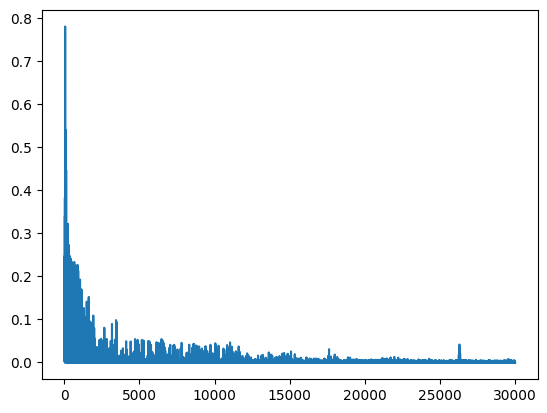

In [39]:
plt.plot(np.array(loss_array).reshape(30000))

Text(0, 0.5, 'Reality')

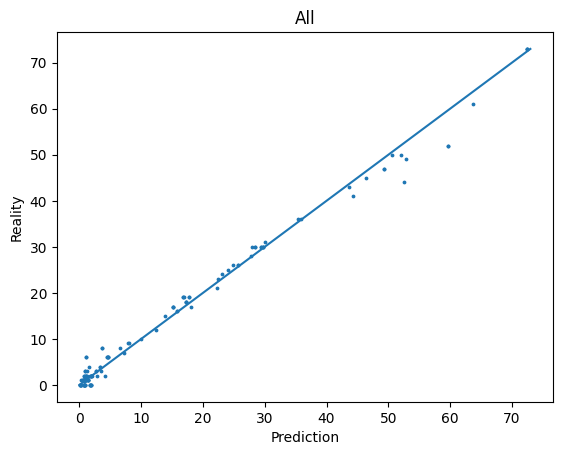

In [40]:
plt.scatter(p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])))).detach().cpu().numpy()*h3_l7_df.ohca.max(),
            spatial_data[:, -1]*h3_l7_df.ohca.max(),
            s = 3)
plt.plot([0, 73], [0, 73])
plt.title('All')
plt.xlabel('Prediction')
plt.ylabel('Reality')

In [41]:
# p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])))).detach().cpu().numpy()*h3_l7_df.ohca.max()-
# spatial_data[:, -1].reshape(137, 1)*h3_l7_df.ohca.max()

Text(0, 0.5, 'Number of OHCA')

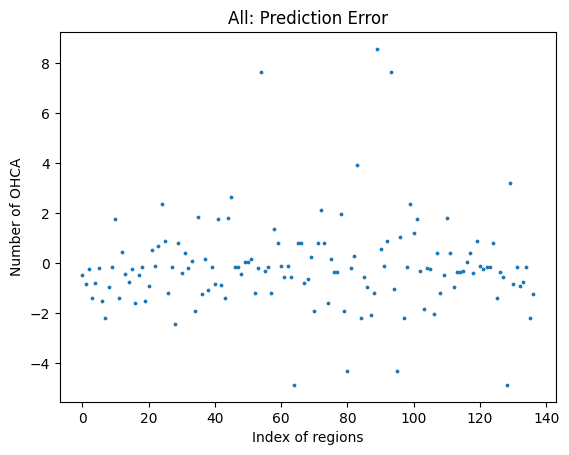

In [51]:
plt.scatter(np.arange(spatial_data.shape[0]),
            p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])))).detach().cpu().numpy()*h3_l7_df.ohca.max()-
            spatial_data[:, -1].reshape(137, 1)*h3_l7_df.ohca.max(),
            s = 3)
plt.title('All: Prediction Error')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

C:\Users\Yuan\AppData\Local\Temp\ipykernel_11620\2273550375.py:2: RuntimeWarning: divide by zero encountered in divide
  (p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])))).detach().cpu().numpy()*h3_l7_df.ohca.max()-


Text(0, 0.5, 'Number of OHCA')

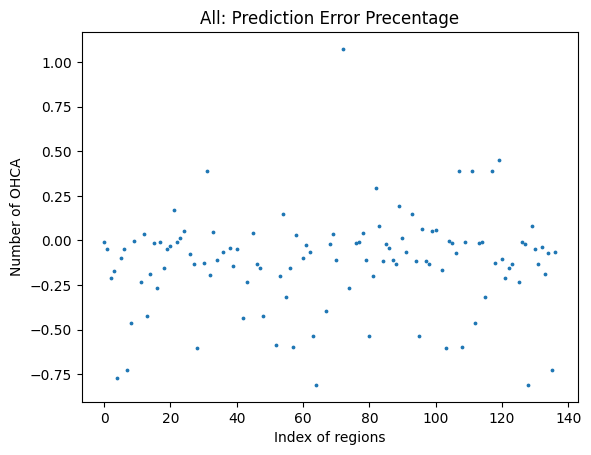

In [52]:
plt.scatter(np.arange(spatial_data.shape[0]),
            (p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])))).detach().cpu().numpy()*h3_l7_df.ohca.max()-
            spatial_data[:, -1].reshape(137, 1)*h3_l7_df.ohca.max())/spatial_data[:, -1].reshape(137, 1)/h3_l7_df.ohca.max(),
            s = 3)
plt.title('All: Prediction Error Precentage')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

In [210]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

x = spatial_data[:, :-1]
y = spatial_data[:, -1]

lr.fit(x, y)

LinearRegression()

In [211]:
x.shape, lr.coef_.shape

((137, 52), (52,))

Text(0.5, 0, 'Index of Features')

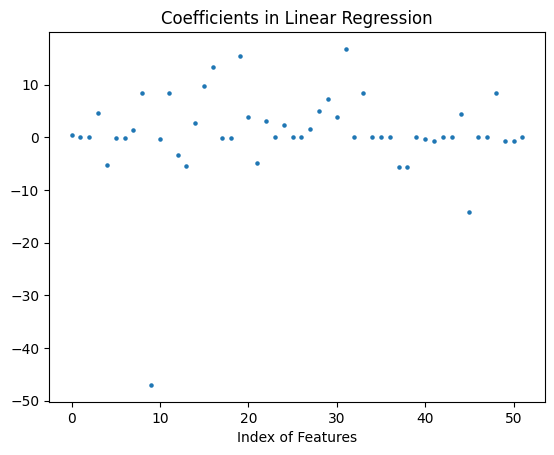

In [212]:
plt.title('Coefficients in Linear Regression')
plt.scatter(np.arange(lr.coef_.shape[0]), lr.coef_, s=5)
plt.xlabel('Index of Features')

In [213]:
np.concatenate( (np.sort(np.abs(lr.coef_))[::-1].reshape(-1, 1),
                    np.argsort(np.abs(lr.coef_))[::-1].reshape(-1, 1),
                    np.array(h3_l7_df.columns[1:-1])[np.argsort(np.abs(lr.coef_))[::-1]].reshape(-1, 1)),    
                axis=1)

array([[47.032768498962774, 9, 'restaurant'],
       [16.78577273213122, 31, 'clinic'],
       [15.358119842167975, 19, 'bank'],
       [14.19459634665047, 45, 'payment_centre'],
       [13.31925842077464, 16, 'toilets'],
       [9.698673454100572, 15, 'fire_station'],
       [8.495681432401394, 33, 'nightclub'],
       [8.495681432401353, 11, 'theatre'],
       [8.495681432401348, 8, 'stage'],
       [8.49568143240132, 48, 'bar'],
       [7.256817415752044, 29, 'cinema'],
       [5.558403333545161, 38, 'prison'],
       [5.558403333545161, 37, 'townhall'],
       [5.407600522652585, 13, 'post_office'],
       [5.256797711761598, 4, 'hospital'],
       [4.995361475131881, 28, 'pub'],
       [4.831248190191085, 21, 'community_centre'],
       [4.520424454611803, 3, 'college'],
       [4.331020910275903, 44, 'driving_school'],
       [3.9464536818350986, 20, 'ice_cream'],
       [3.9464536818350164, 30, 'animal_shelter'],
       [3.3681849860879343, 12, 'library'],
       [3.070667860510

In [48]:
np.array(h3_l7_df.columns[1:-1])[np.argsort(np.abs(lr.coef_))[::-1]]

array(['police', 'pub', 'shelter', 'exhibition_centre', 'payment_centre',
       'prison', 'townhall', 'stage', 'bar', 'nightclub', 'car_rental',
       'marketplace', 'cafe', 'bank', 'bus_station', 'grave_yard', 'dojo',
       'doctors', 'school', 'clinic', 'cinema', 'animal_shelter',
       'gambling', 'car_wash', 'toilets', 'post_office', 'veterinary',
       'ice_cream', 'university', 'college', 'driving_school',
       'social_facility', 'fast_food', 'theatre', 'library', 'restaurant',
       'pharmacy', 'parking', 'childcare', 'dentist', 'fire_station',
       'ranger_station', 'kindergarten', 'community_centre', 'shower',
       'place_of_worship', 'fuel', 'hospital', 'arts_centre', 'bbq',
       'studio', 'bicycle_parking'], dtype=object)

In [49]:
np.concatenate( (np.sort(lr.coef_)[::-1].reshape(-1, 1),
                    np.argsort(lr.coef_)[::-1].reshape(-1, 1),
                    np.array(h3_l7_df.columns[1:-1])[np.argsort(lr.coef_)[::-1]].reshape(-1, 1)),    
                axis=1)

array([[2.1267350490939103, 22, 'police'],
       [0.4902985553914265, 24, 'shelter'],
       [0.2763332600901727, 43, 'car_rental'],
       [0.2763332600901727, 42, 'marketplace'],
       [0.25647112376886094, 19, 'bank'],
       [0.20872508432238396, 46, 'dojo'],
       [0.20872508432238276, 39, 'doctors'],
       [0.1906968304265163, 0, 'school'],
       [0.13522079323702618, 47, 'gambling'],
       [0.13356312748319854, 18, 'car_wash'],
       [0.1284562176228059, 16, 'toilets'],
       [0.12223673690163478, 13, 'post_office'],
       [0.11148013195216752, 20, 'ice_cream'],
       [0.10219855637914131, 3, 'college'],
       [0.07999059337380032, 44, 'driving_school'],
       [0.06223423344523821, 11, 'theatre'],
       [0.05379064102280784, 12, 'library'],
       [0.03957937778284887, 17, 'childcare'],
       [0.03765899596606678, 40, 'dentist'],
       [0.03351853131720828, 15, 'fire_station'],
       [0.02074183514810085, 26, 'shower'],
       [0.006505059295830895, 6, 'place_of_

In [50]:
# mutual information

def mlp(dim, hidden_dim, output_dim, layers, activation):
    """Create a mlp from the configurations."""
    activation = {
        'relu': nn.ReLU
    }[activation]

    seq = [nn.Linear(dim, hidden_dim), activation()]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation()]
    seq += [nn.Linear(hidden_dim, output_dim)]

    return nn.Sequential(*seq)

class SeparableCritic(nn.Module):
    """Separable critic. where the output value is g(x) h(y). """

    def __init__(self, x_dim, y_dim, hidden_dim, embed_dim, layers, activation, **extra_kwargs):
        super(SeparableCritic, self).__init__()
        self._g = mlp(x_dim, hidden_dim, embed_dim, layers, activation)
        self._h = mlp(y_dim, hidden_dim, embed_dim, layers, activation)

    def forward(self, x, y):
        scores = torch.matmul(self._h(y), self._g(x).t())
        return scores


class ConcatCritic(nn.Module):
    """Concat critic, where we concat the inputs and use one MLP to output the value."""

    def __init__(self, x_dim, y_dim, hidden_dim, layers, activation, **extra_kwargs):
        super(ConcatCritic, self).__init__()
        # output is scalar score
        self._f = mlp(x_dim+y_dim, hidden_dim, 1, layers, activation)

    def forward(self, x, y):
        batch_size = x.size(0)
        # Tile all possible combinations of x and y
        x_tiled = torch.stack([x] * batch_size, dim=0)
        y_tiled = torch.stack([y] * batch_size, dim=1)
        # xy is [batch_size * batch_size, x_dim + y_dim]
        xy_pairs = torch.reshape(torch.cat((x_tiled, y_tiled), dim=2), [
                                 batch_size * batch_size, -1])
        # Compute scores for each x_i, y_j pair.
        scores = self._f(xy_pairs)
        return torch.reshape(scores, [batch_size, batch_size]).t()

data_params = {
    'x_dim': 204,
    'y_dim': 1,
    'batch_size': 64,
    'cubic': None
}

critic_params = {
    'x_dim': 204,
    'y_dim': 1,
    'layers': 3,
    'embed_dim': 512,
    'hidden_dim': 512,
    'activation': 'relu',
}

opt_params = {
    'iterations': 20000,
    'learning_rate': 2e-4,
}

estimator = 'smile'
clip = 5.0

CRITICS = {
    'separable': SeparableCritic,
    'concat': ConcatCritic,
}
critic = CRITICS['separable'](rho=None, **critic_params)
opt_crit = optim.Adam(critic.parameters(), lr=opt_params['learning_rate'])

estimates = []

"""Main training loop that estimates time-varying MI."""
# Ground truth rho is only used by conditional critic
window_size=100
for i in tqdm(range(opt_params['iterations'])):
    # h3_l7_id = np.random.choice(spatial_data.shape[0], window_size)

    x = torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))

    ohca = spatial_data[h3_l7_id, -1].reshape(-1,1)
    y = torch.autograd.Variable(torch.FloatTensor(ohca))
    
    x, y = x, y
    scores = critic(x, y)
    if clip is not None:
        f_ = torch.clamp(scores, -clip, clip)
    else:
        f_ = scores

    if f_.isnan().any():
        print(i, 'f_')
        break
    
    batch_size = f_.size(0)
    logsumexp = torch.logsumexp(
        f_ - torch.diag(np.inf * torch.ones(batch_size)), dim=(0, 1))
    try:
        if len((0, 1)) == 1:
            num_elem = batch_size - 1.
        else:
            num_elem = batch_size * (batch_size - 1.)
    except ValueError:
        num_elem = batch_size - 1
    z = logsumexp - torch.log(torch.tensor(num_elem))
    dv = scores.diag().mean() - z
    """Lower bound on Jensen-Shannon divergence from Nowozin et al. (2016)."""
    f_diag = scores.diag()
    first_term = -F.softplus(-f_diag).mean()
    n = scores.size(0)
    if n == 1: n = 2
    second_term = (torch.sum(F.softplus(scores)) -
                torch.sum(F.softplus(f_diag))) / (n * (n - 1.))
    js = first_term - second_term


    with torch.no_grad():
        dv_js = dv - js

    if dv.isnan():
        print(i, 'dv', num_elem)
        break

    mi = js + dv_js
    loss = -mi

    loss.backward()
    opt_crit.step()

    mi = mi.detach().cpu().numpy()
    estimates.append(mi)

mis =  np.array(estimates)
plt.plot(mis[np.abs(mis)<2])

  0%|          | 0/20000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (137x52 and 204x512)

In [52]:
plt.scatter(np.arange(len(mis[np.abs(mis)<2])), mis[np.abs(mis)<2], s = 1)

NameError: name 'mis' is not defined

In [73]:
h3_l7_id1 = np.random.choice(spatial_data.shape[0]-1, 2000)
t_pivot1 = np.random.choice(temporal_train_data.shape[0]-window_size-1, 2000)

pivot = np.random.choice(len(ohca_occur_train), 1000)
t_pivot2 = ohca_occur_train[pivot][:, 0] - window_size
h3_l7_id2 = ohca_occur_train[pivot][:, 1]

h3_l7_id = np.concatenate((h3_l7_id1.reshape(-1,1), h3_l7_id2.reshape(-1,1)), axis=0)
t_pivot = np.concatenate((t_pivot1.reshape(-1,1), t_pivot2.reshape(-1,1)), axis=0) 

s_fea = np.array(spatial_data[h3_l7_id]).reshape(3000, -1)

# t_fea = torch.autograd.Variable(torch.FloatTensor(
#             np.concatenate((temporal_train_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]],
#                             police_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
#                     ))
# # X_pred = regr_net(Y)
# features = (torch.cat( (s_fea , t_fea[-1]), dim=0 ))

t_pivot += window_size
h3_l7_id_ = h3_l7_id + 4

t_fea = np.concatenate((temporal_train_data[t_pivot, 0:4].reshape(3000,4), temporal_train_data[t_pivot-1, h3_l7_id_].reshape(3000,1)), axis=1) 
t_fea = np.concatenate((t_fea, police_data[t_pivot, h3_l7_id].reshape((-1, 1))), axis=1)

x = np.concatenate((s_fea, t_fea), axis=1)
y = np.array([temporal_train_data[t_pivot, 4+h3_l7_id]]).reshape((3000, -1))
xy = np.concatenate((x, y), axis=1)

xy = pd.DataFrame(xy)
corr_array = np.array(xy.corr().loc[:, 210])
np.where(np.abs(corr_array) > 0.2), corr_array[np.where(np.abs(corr_array) > 0.2)]
for i in np.where(np.abs(corr_array) > 0.2)[0]:
    print(i)
    plt.scatter(xy.loc[:, i], xy.loc[:, 210], s=5)
    plt.show()

In [90]:
ohca_occur_test = ohca_occur_train

In [91]:
p_pred_ls = []

correct = 0

for i in range(len(ohca_occur_test)):
    t_pivot = ohca_occur_test[i][0] - window_size
    h3_l7_id = ohca_occur_test[i][1]

    s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id])))

    h_state = None
    # t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(temporal_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]])), h_state)
    t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(
                            np.concatenate(
                                (temporal_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]], police_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
                            )), h_state)

    p_pred = p_net(torch.cat( (s_fea , t_fea[-1]), dim=0 ))
    p_pred_ls.append(p_pred.detach().cpu().float().item())
    if p_pred > 0.501851 and temporal_data[t_pivot+window_size, 4+h3_l7_id] >= 1:
        correct +=1

    if i % 20 == 0:
        print(s_fea, t_fea, p_pred)

correct/len(ohca_occur_test)

/home/dell/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0.4601, 0.4601], device='cuda:0',
       grad_fn=<SigmoidBackward0>) tensor([[-4.3206,  1.9626,  2.5399,  ...,  2.5870, -3.6538, -2.1828],
        [-5.1360,  2.1629,  2.3719,  ...,  2.3946, -7.2491, -2.4680],
        [-5.4491,  2.3547,  2.5648,  ...,  2.5879, -7.4173, -2.6785],
        ...,
        [-5.4565,  2.3567,  2.5655,  ...,  2.5885, -7.4360, -2.6815],
        [-5.4564,  2.3567,  2.5655,  ...,  2.5885, -7.4360, -2.6815],
        [-5.4565,  2.3567,  2.5655,  ...,  2.5885, -7.4360, -2.6815]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0.5052], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0

1.0

[0.5018509030342102, 0.5018510222434998, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018509030342102, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018511414527893, 0.5018509030342102, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018508434295654, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.5018510818481445, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.5018509030342102, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018508434

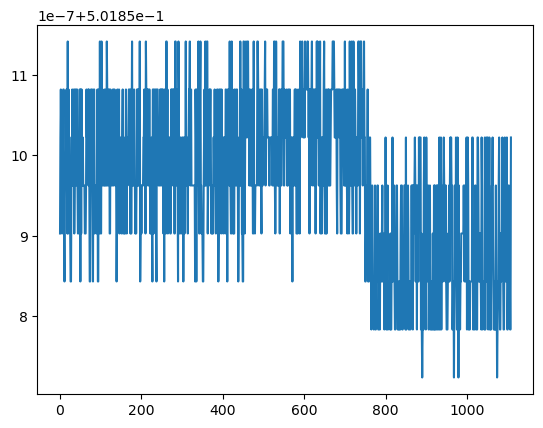

In [19]:
print(p_pred_ls)
plt.plot(p_pred_ls)

In [20]:
p_pred = []
correct = 0
occurred = 0
for i in range(600):
    h3_l7_id = np.random.randint(spatial_data.shape[0]-1)
    t_pivot = np.random.randint(temporal_test_data.shape[0]-window_size-1)

    s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id])))

    h_state = None
    # t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(temporal_test_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]])), h_state)
    t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(
                            np.concatenate(
                                (temporal_test_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]], police_test_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
                            )), h_state)
    p_pred = p_net(torch.cat( (s_fea , t_fea[-1]), dim=0 ))
    p_pred_ls.append(p_pred.detach().cpu().float().item())

    if p_pred < 0.4 and temporal_test_data[t_pivot+window_size, 4+h3_l7_id] == 0:
        correct += 1
    elif temporal_test_data[t_pivot+window_size, 4+h3_l7_id] >= 1:
        occurred += 1

    # print(t_pivot, h3_l7_id, temporal_test_data[t_pivot+window_size, 4+h3_l7_id], p_pred)
correct/(600-occurred)

0.0

[0.5018509030342102, 0.5018510222434998, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018509030342102, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018511414527893, 0.5018509030342102, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018508434295654, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.5018510818481445, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.5018509030342102, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018508434

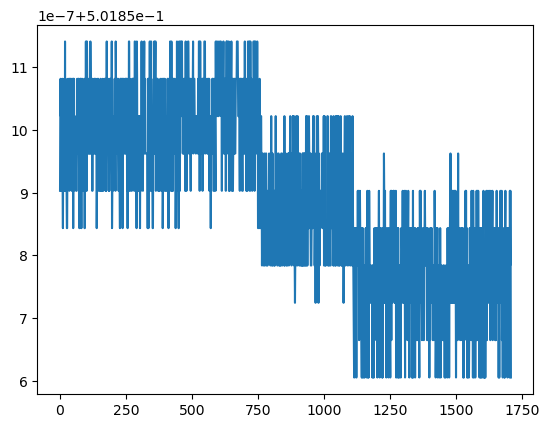

In [21]:
print(p_pred_ls)
plt.plot(p_pred_ls)

[0.5018509030342102, 0.5018510222434998, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018509030342102, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018511414527893, 0.5018509030342102, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018508434295654, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.5018510818481445, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.5018509030342102, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018508434

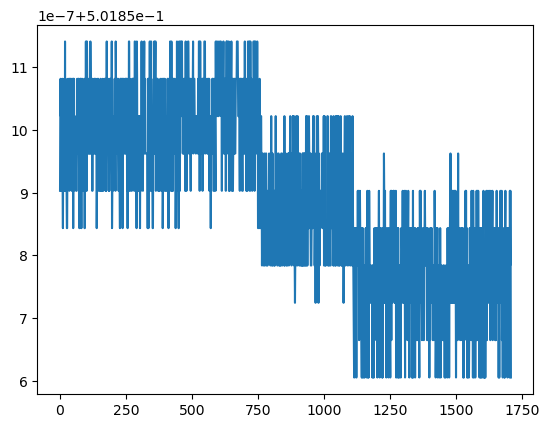

In [22]:
print(p_pred_ls)
plt.plot(p_pred_ls)